In [1]:
#Download and unzip files
!pip3 install scikit-learn
# !pip install "wheel==0.34.2"
!pip install "wheel==0.35.0"
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip 
!unzip cities_train.zip 
from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--2021-11-02 00:42:28--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10973 (11K) [text/plain]
Saving to: ‘cities_test.txt.2’

cities_test.txt.2   100%[===================>]  10.72K  --.-KB/s    in 0s      

2021-11-02 00:42:28 (151 MB/s) - ‘cities_test.txt.2’ saved [10973/10973]

--2021-11-02 00:42:28--  http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [application/zip]

In [ ]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"
#Verify CUDA acceleration should print cuda:0
print(device)

In [ ]:
# Mount your google drive. 
# Use this to save your PyTorch model for submission
from google.colab import drive
drive.mount('/content/gdrive')
# !mkdir /content/gdrive/My\ Drive/cis530_hw6
#Test drive access. 
#You should have a test.txt under a new folder cis530_hw6 in your Google drive
with open('/content/gdrive/My Drive/cis530_hw6/test.txt', 'w') as f:
  f.write('This is a test!')

In [2]:
#main_classify.py
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score
# from models import *
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
idx_dict = {languages[i]:i for i in range(len(languages))}
n_categories = len(languages)
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
baseDir = '.'

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
def getWords(baseDir, lang, train = True):
    if train:
      filepath = os.path.join(baseDir,'train',lang+'.txt') # /content/train/xx.txt
    else:
      filepath = os.path.join(baseDir,'val',lang+'.txt')
    f = codecs.open(filepath, "r",encoding='utf-8', errors='ignore')
    words_arr = [line.strip('\n') for line in f.readlines()]
    return words_arr

'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    idx = idx_dict[lang]
    return [idx]*length
    pass

'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    X, y = [],[] 
    # X = [ duck, cat, moose, bonjour, soleil, froid, ... ] y = [ 0, 0, 0, 1, 1, 1, ... ]
    for lang in languages:
      curwords = getWords(baseDir, lang, train)
      X += curwords
      y += getLabels(lang,len(curwords))
      # print(len(X),len(y))
      # print(X[:5])
      # print(y[:5])
    return np.array(X),np.array(y)
    pass
def letter_to_index(letter):
    return all_letters.find(letter)
'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor
    pass

'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return languages[category_i], category_i
    pass
  
# newly added
def randomTrainingExample():
    lang = languages[random.randint(0, len(languages) - 1)] # 'fr'
    cur_lang = getWords(baseDir, lang)
    line = cur_lang[random.randint(0, len(cur_lang) - 1)]
    # line = randomChoice(category_lines[category])
    # category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    category_tensor = torch.tensor([idx_dict[lang]], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return lang, line, category_tensor, line_tensor

'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def random_training_pair(X, y):
    assert len(X) == len(y)
    idx = random.randint(0, len(X) - 1)
    xi = X[idx]
    xi = line_to_tensor(xi)
    yi = y[idx]
    yi = torch.tensor([yi], dtype=torch.long)
    return xi, yi, X[idx], languages[y[idx]]
    pass 

# Newly added, Just return an output given a line
def evaluate_one_line(model,line_tensor):
    hidden = model.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output
'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
def predict(model, X, y):
    ret = []
    for input_line in X:
      # print('\n> %s' % input_line)
      with torch.no_grad():
          output = evaluate_one_line(model,line_to_tensor(input_line))
          _, category = category_from_output(output)
          ret.append(category)
          # # Get top N categories
          # topv, topi = output.topk(n_predictions, 1, True)
          # predictions = []

          # for i in range(n_predictions):
          #     value = topv[0][i].item()
          #     category_index = topi[0][i].item()
          #     print('(%.2f) %s' % (value, all_categories[category_index]))
          #     predictions.append([value, all_categories[category_index]])
    return ret

    pass

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    pred_y = predict(model, X, y)
    return accuracy_score(pred_y,y)
    pass

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    xi, yi, line,category = random_training_pair(X, y)
    hidden = model.init_hidden()
    model.zero_grad()
    optimizer.zero_grad()
    # print('xi[0].shape',xi[0].shape,'yi',yi)
    # for i in range(line_tensor.size()[0]):
    # output, hidden = model(xi, hidden)
    for i in range(xi.size()[0]):
        output, hidden = model(xi[i], hidden)

    loss = criterion(output, yi)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in model.parameters():
        # p.data.add_(p.grad.data, alpha=-learning_rate)
    
    optimizer.step()
    return output, loss.item(), line,category,optimizer
    pass

'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
def run(learning_rate, n_iters, n_hidden, optim = 'SGD',lr_scheduler=0):
    import time
    import math
    import copy
    # origin_lr = learning_rate
    X,y = readData(baseDir)
    val_X, val_y = readData(baseDir, train=False)
    print('train len:',len(X),'dev len:',len(val_X))
    # n_iters = 100000
    # n_iters = 400000
    print_every = 5000
    plot_every = 1000
    dev_every = 5000
    # DEBUG
    # n_iters, print_every, plot_every = n_iters//100, print_every//100, plot_every//100
    # learning_rate = 0.0005
    print('learning_rate',learning_rate,'n_iters',n_iters,'n_hidden',n_hidden, 'optim',optim, 'lr_scheduler',lr_scheduler)

    current_loss = 0
    all_losses = []
    dev_losses = []
    dev_acc_list = []
    best_model = None
    best_val_acc = float('-inf')
    model = CharRNNClassify(n_letters, n_hidden, n_categories)
    if optim == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optim == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    if lr_scheduler:
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=dev_every, gamma=0.99)


    def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)

    start = time.time()
    for iter in range(1, n_iters + 1):
      model.train()
      # category, line, category_tensor, line_tensor = randomTrainingExample()
      output, loss, line,category,optimizer = trainOneEpoch(model, criterion, optimizer, X, y)
      current_loss += loss
      
      # Print iter number, loss, name and guess
      if iter % print_every == 0:
          guess, guess_i = category_from_output(output)
          correct = '✓' if guess == category else '✗ (%s)' % category
          print(learning_rate)
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

      if iter % dev_every ==0:
          model.eval()
          eval_loss = 0
          for k in range(len(val_X)):
            hidden = model.init_hidden()
            # xi = line_to_tensor(X[k])
            xi = line_to_tensor(val_X[k])
            # yi = torch.tensor([y[k]], dtype=torch.long)
            yi = torch.tensor([val_y[k]], dtype=torch.long)
            for i in range(xi.size()[0]):
              output, hidden = model(xi[i], hidden)
            loss = criterion(output, yi)
            eval_loss += loss
          dev_losses.append(eval_loss/len(val_X))
          val_acc = calculateAccuracy(model, val_X, val_y)
          dev_acc_list.append(val_acc)
          print('dev loss',eval_loss/len(val_X), 'dev acc',val_acc)
          if val_acc>best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
          # output, loss, line,category = trainOneEpoch(model, criterion, optimizer, val_X, val_y)
          # current_loss += loss
          # learning_rate = origin_lr * 0.95 **(n_iters/dev_every)
      if lr_scheduler:
        scheduler.step()
    print('best_val_acc',best_val_acc)
    return all_losses, best_model, dev_losses, dev_acc_list

In [3]:
#models.py
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F
criterion = nn.NLLLoss()
# learning_rate = 0.002
# n_hidden = 128
'''
Please add default values for all the parameters of __init__.
'''
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type = 'RNN'):
        # pass
        super(CharRNNClassify, self).__init__()
        self.model_type = model_type

        self.hidden_size = hidden_size
        self.encoder = nn.Linear(input_size, hidden_size)

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

        self.gru = nn.GRU(input_size + hidden_size, hidden_size, 1) # n_layers = 1
        # self.gruo = nn.GRU(input_size + hidden_size, output_size, 1)
        self.linear = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        # self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden=None):
        # pass
        # print(hidden.shape)
        # print(input[:,:].shape)
        input = torch.cat((input, hidden), 1)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)

        # input = self.encoder(input)
        # print(input.shape)
        # print(input.view(1, 1, -1).shape)
        # print(hidden.shape)
        # print(hidden.view(1,1,-1).shape)
        output, hidden = self.gru(input.view(1, 1, -1), hidden.view(1, 1, -1))
        output = self.linear(output.view(1, -1))

        output = self.softmax(output)
        # print('hidden[:,:].shape',hidden.view(1,-1).shape)
        return output, hidden.view(1,-1)

    def init_hidden(self):
        # pass
        return torch.zeros(1, self.hidden_size)
# n_hidden = 128
# rnn = CharRNNClassify(n_letters, n_hidden, n_categories)
# all_losses, model, dev_losses, dev_acc_list = run(0.0005, 400000, 128)

#### train

In [ ]:
result = {}
# for lr, iters in [(0.002, 250),(0.002,400),(0.0005,250),(0.0005,350),(0.0005,400),(0.0005,600),
for lr, iters in [(0.0002,400),(0.0003,400)]:
    for hidden_num in [32, 64, 128]:
      # all_losses, model = run(lr, iters*1000, hidden_num,lr_scheduler=1)
      all_losses, model, dev_losses, dev_acc_list = run(lr, iters*1000, hidden_num, lr_scheduler=0)
      val_X, val_y = readData(baseDir, train = False)
      acc = calculateAccuracy(model, val_X, val_y)
      print(acc)
      result[(lr,iters,hidden_num)]=acc

In [6]:
# result = {}
# # for lr, iters in [(0.002, 250),(0.002,400),(0.0005,250),(0.0005,350),(0.0005,400),(0.0005,600),
# for lr, iters in [(0.0002,400),(0.0003,400)]:
#     for hidden_num in [32, 64, 128]:
all_losses, model, dev_losses, dev_acc_list = run(0.001, 200000, 64)
# all_losses, model, dev_losses, dev_acc_list = run(0.0005, 400000, 256)
val_X, val_y = readData(baseDir, train = False)
acc = calculateAccuracy(model, val_X, val_y)

print(acc)
# result[(lr,iters,hidden_num)]=acc

train len: 27000 dev len: 900
learning_rate 0.001 n_iters 200000 n_hidden 64 optim SGD lr_scheduler 0
0.001
5000 2% (0m 36s) 2.2011 massikier / fi ✗ (za)
dev loss tensor(2.1858, grad_fn=<DivBackward0>) dev acc 0.19555555555555557
0.001
10000 5% (1m 18s) 2.2077 lishantang / in ✗ (cn)
dev loss tensor(2.1746, grad_fn=<DivBackward0>) dev acc 0.2088888888888889
0.001
15000 7% (1m 59s) 2.1076 goth jiye shah / af ✗ (pk)
dev loss tensor(2.1324, grad_fn=<DivBackward0>) dev acc 0.25555555555555554
0.001
20000 10% (2m 41s) 2.0916 ylinampa / in ✗ (fi)
dev loss tensor(2.0385, grad_fn=<DivBackward0>) dev acc 0.2688888888888889
0.001
25000 12% (3m 22s) 1.6656 normandel / fr ✓
dev loss tensor(1.9338, grad_fn=<DivBackward0>) dev acc 0.2833333333333333
0.001
30000 15% (4m 3s) 0.8458 jhok mahmud khan / pk ✓
dev loss tensor(1.8758, grad_fn=<DivBackward0>) dev acc 0.31555555555555553
0.001
35000 17% (4m 45s) 2.1400 turkhauta / pk ✗ (fi)
dev loss tensor(1.8944, grad_fn=<DivBackward0>) dev acc 0.287777777777

In [ ]:
val_X, val_y = readData(baseDir, train = False)
acc = calculateAccuracy(model, val_X, val_y)
print(acc)

0.5455555555555556


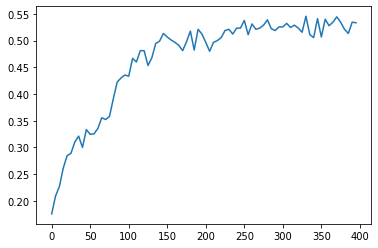

In [ ]:
plt.figure()
dev_x = [i for i in range(0,len(all_losses),5)]
plt.plot(dev_x,dev_acc_list)
plt.show()

In [ ]:
# torch.save(model.state_dict(), os.path.join('/content/gdrive/My Drive/cis530_hw6','model_weights_lr5e-4_iter400k_hidden128_SGD_acc545.pth'))

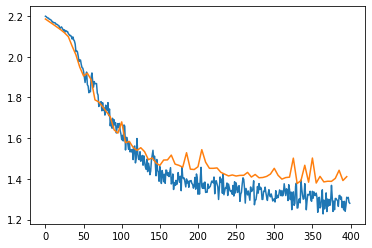

In [ ]:
plt.figure()
plt.plot(all_losses)
# print(len(dev_losses))
# print(len(all_losses))
dev_x = [i for i in range(0,len(all_losses),5)] #[:70]
# print(len(dev_x))
# print(type(dev_losses))
# dev_losses_interval = [sum(dev_losses[i:i+5])/4 for i in range(0,len(dev_losses),4)]
# print(len(dev_x),len(dev_losses_interval))
plt.plot(dev_x,dev_losses)
plt.show()
# torch.save(model.state_dict(), os.path.join(baseDir,'model_weights_lr5e-4.pth'))

#### evaluate

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(model):
  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      output = evaluate_one_line(model,line_tensor)
      guess, guess_i = category_from_output(output)
      category_i = languages.index(category)

      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()
  return confusion
def confusion_mat_plot(confusion):
  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + languages, rotation=90)
  ax.set_yticklabels([''] + languages)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

In [ ]:
# model_path = '/content/gdrive/My Drive/cis530_hw6/model_weights.pth'
model_path = '/content/gdrive/My Drive/cis530_hw6/model_weights_lr5e-4_iter400k_hidden256_SGD_acc545.pth'
model = CharRNNClassify(n_letters, 256, n_categories)
model.load_state_dict(torch.load(model_path))
model.eval() #To predict
val_X, val_y = readData(baseDir, train = False)
acc = calculateAccuracy(model, val_X, val_y)
print(acc)


0.5455555555555556


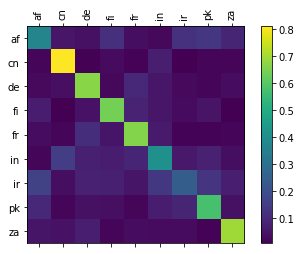

In [ ]:
# confusion
confusion = evaluate(model)
confusion_mat_plot(confusion)

In [ ]:
confusion

tensor([[0.3734, 0.0561, 0.0446, 0.1159, 0.0374, 0.0258, 0.1212, 0.1337, 0.0918],
        [0.0169, 0.8110, 0.0110, 0.0321, 0.0143, 0.0734, 0.0076, 0.0169, 0.0169],
        [0.0290, 0.0390, 0.6670, 0.0254, 0.0971, 0.0572, 0.0290, 0.0209, 0.0354],
        [0.0722, 0.0073, 0.0466, 0.6435, 0.0868, 0.0548, 0.0302, 0.0494, 0.0091],
        [0.0345, 0.0186, 0.1137, 0.0541, 0.6617, 0.0643, 0.0158, 0.0158, 0.0214],
        [0.0213, 0.1539, 0.0782, 0.0697, 0.0893, 0.4099, 0.0621, 0.0799, 0.0357],
        [0.1616, 0.0368, 0.0799, 0.0781, 0.0530, 0.1391, 0.2451, 0.1329, 0.0736],
        [0.0958, 0.0181, 0.0425, 0.0397, 0.0226, 0.0714, 0.0894, 0.5772, 0.0434],
        [0.0516, 0.0458, 0.0750, 0.0195, 0.0341, 0.0321, 0.0302, 0.0146, 0.6972]])

In [ ]:
idx = np.argsort(confusion.flatten())
for i in idx[-11:]:
  idxrc = np.where(confusion==confusion.flatten()[i])
  if idxrc[0]!=idxrc[1]:
    print(idxrc)
    print(confusion.flatten()[i])

(array([5]), array([1]))
tensor(0.1539)
(array([6]), array([0]))
tensor(0.1616)


## Test

In [ ]:
def get_test_data(test_path):
    f = codecs.open(test_path, "r",encoding='utf-8', errors='ignore')
    words_arr = [line.strip('\n') for line in f.readlines()]
    return words_arr
def get_test_res(test_X,output_path):
    output_file = open(output_path,'w')
    model.eval()
    for k in range(len(test_X)):
      hidden = model.init_hidden()
      xi = line_to_tensor(test_X[k])
      # yi = torch.tensor([y[k]], dtype=torch.long)
      for i in range(xi.size()[0]):
        output, hidden = model(xi[i], hidden)
      guess, guess_i = category_from_output(output)
      # print(guess,guess_i)
      print(guess,file = output_file)
    output_file.close()
      # loss = criterion(output, yi)
      # eval_loss += loss
    # dev_losses.append(eval_loss/len(val_X))



In [ ]:
test_path = os.path.join(baseDir,'cities_test.txt')
test_X = get_test_data(test_path)
# print(len(test_X),test_X[:4])
output_path = '/content/gdrive/My Drive/cis530_hw6/result_lr5e-4_iter400k_hidden256_SGD_acc545.txt'
get_test_res(test_X,output_path)

## debug codes

In [ ]:
# input = letter_to_tensor('A')
# hidden = torch.zeros(1, n_hidden)

# output, next_hidden = rnn(input, hidden)
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(category_from_output(output)) # ('in', 5)

X,y = readData('/content')
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
a,b = trainOneEpoch(rnn, criterion, optimizer, X, y)
print(a,b) # output tensor, float loss

tensor([[-2.1099, -2.3297, -2.2676, -2.2165, -2.1478, -2.0829, -2.2670, -2.2091,
         -2.1704]], grad_fn=<LogSoftmaxBackward>)
('in', 5)
xi[0].shape torch.Size([1, 57]) yi tensor([1])
tensor([[-2.1521, -2.2280, -2.2782, -2.1229, -2.1643, -2.1325, -2.3089, -2.1659,
         -2.2398]], grad_fn=<LogSoftmaxBackward>) 2.2280163764953613


In [ ]:
words = getWords('/content','fr')
# print(words[:10])
readData('/content', train=True)

print(line_to_tensor('Jones').size())

letter J
letter o
letter n
letter e
letter s
torch.Size([5, 1, 57])


In [ ]:
def prev_run(learning_rate, n_iters, n_hidden):
    import time
    import math
    X,y = readData(baseDir)
    # n_iters = 100000
    print_every = 5000
    plot_every = 1000
    # DEBUG
    # n_iters, print_every, plot_every = n_iters//100, print_every//100, plot_every//100
    # learning_rate = 0.0005
    print('learning_rate',learning_rate,'iter',n_iters,'n_hidden',n_hidden)

    current_loss = 0
    all_losses = []

    model = CharRNNClassify(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)

    start = time.time()
    for iter in range(1, n_iters + 1):
      # category, line, category_tensor, line_tensor = randomTrainingExample()
      output, loss, line,category = trainOneEpoch(model, criterion, optimizer, X, y)
      current_loss += loss

      # Print iter number, loss, name and guess
      if iter % print_every == 0:
          guess, guess_i = category_from_output(output)
          correct = '✓' if guess == category else '✗ (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0
    
    return all_losses, model